<a href="https://colab.research.google.com/github/dooooing/2023-ESAA-/blob/main/0908_%EC%A0%9C%EC%B6%9C__%ED%95%B8%EC%A6%88%EC%98%A8_3%EC%9E%A5_%EB%B6%84%EB%A5%98_p_127_154.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3.1 MNIST

In [1]:
# 사이킷런에서 제공하는 헬퍼 함수로 MNIST 데이터셋 내려받기
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

<function matplotlib.pyplot.show(close=None, block=None)>

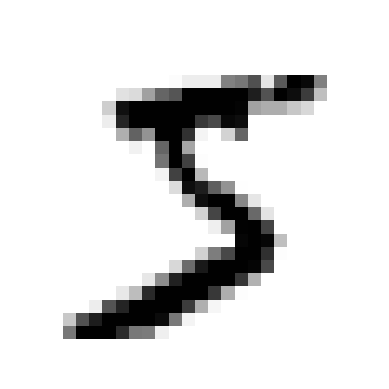

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show

In [5]:
y[0]

'5'

In [6]:
import numpy as np

# y를 문자열에서 정수로 변환
y = y.astype(np.uint8)

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 3.2 이진 분류기 훈련

**이진 분류기**

In [8]:
# 타깃 벡터 만들기
y_train_5 = (y_train == 5) # 5는 True고, 다른 숫자는 모두 False
y_test_5 = (y_test == 5)

**확률적 경사 하강법 (SGD)**

In [9]:
# 모델 설정
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [10]:
# 이미지 감지
sgd_clf.predict([some_digit])

array([ True])

# 3.3 성능 측정

## 3.3.1 교차 검증을 사용한 정확도 측정

**교차 검증 구현**

사이킷런보다 더 많이 제어

cross_val_score() 함수와 유사

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [12]:
# k-겹 교차 검증 (k=3 예시)
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [13]:
# 모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

결론 : 정확도를 분류기의 성능 측정 지표로 선호하지 않음
(특히 불균형한 데이터셋)

## 3.3.2 오차 행렬

**오차 행렬**

클래스 A의 샘플이 클래스 B로 분류된 횟수

In [15]:
# 예측값 만들기
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

**cross_val_predict()**

k-겹 교차 검증 수행 but 평가 점수 반환X, 각 테스트 폴드에서 얻은 예측을 반환

In [16]:
# 오차 행렬 만들기
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

행 : 실제 클래스

열 : 예측한 클래스

array([[53892,   687], [ 1891,  3530]])

[진짜 음성, 거짓 양성], [거짓 음성, 진짜 양성]

In [17]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

**정밀도**

양성 예측의 정확도

TP / (TP+FP)

**재현율 (민감도)**

TP / (TP+FN)

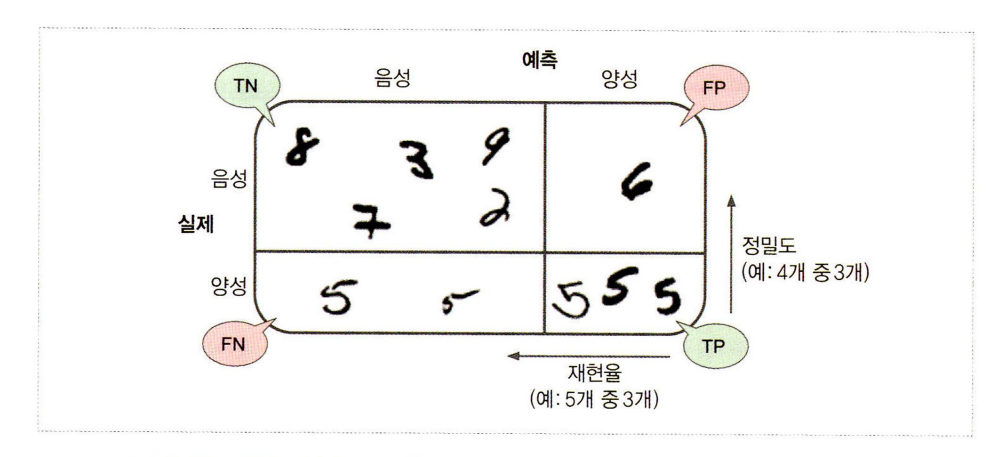

## 3.3.3 정밀도와 재현율

In [18]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [19]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

**F1 score**

정밀도와 재현율의 조화 평균

F1 = 2 / ( 1/정밀도 + 1/재현율 )

In [20]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

**정밀도/재현율 트레이드오프**

목적에 맞게 정밀도/재현율을 고려하여 모델을 골라야 함

## 3.3.4 정밀도/재현율 트레이드오프

**결정 함수**

결정 함수 점수 > 임곗값    => 양성 클래스

**결정 임곗값**

임곗값 증가  =>  재현율 감소, 정밀도 증가
임곗값 감소  =>  재현율 증가, 정밀도 감소

임곗값 지정 못함 but 예측에 사용한 점수 확인 가능

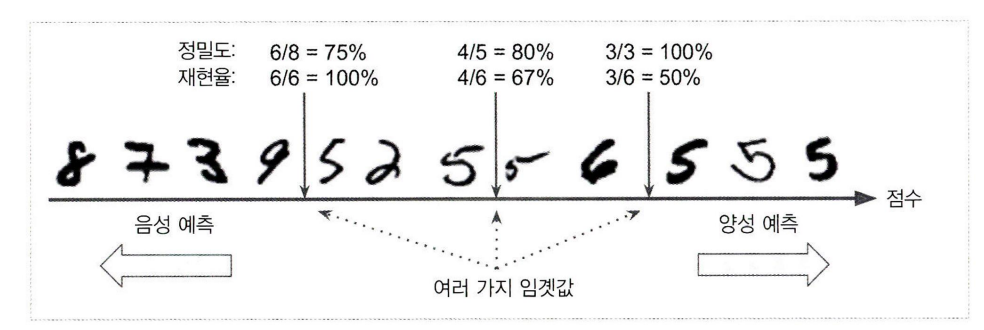

In [21]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [24]:
# 임곗값 0

threshold=0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [25]:
# 임곗값 8000
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

결론 : 임곗값 높이면 재현율 줄어듦

**적절한 임곗값 정하기**

cross_val_predict()로 훈련 세트에 있는 모든 샘플 점수 구하기

결정 점수 반환하도록 지정

In [28]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3 , method = "decision_function")

In [29]:
# precision_recall_curve() 함수로 가능한 모든 임곗값에 대해 정밀도와 재현율 계산
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

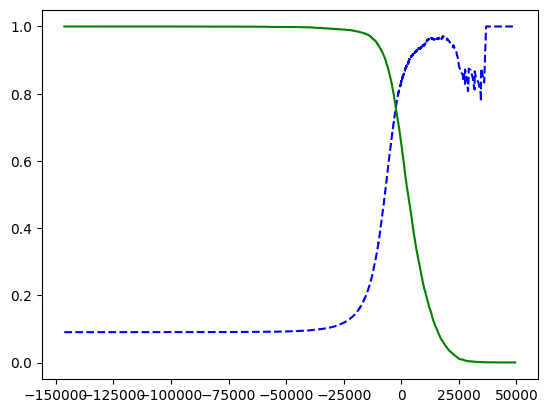

In [30]:
# matplotlib으로 그래프 그리기
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label='정밀도')
  plt.plot(thresholds, recalls[:-1], "g-", label='재현율')
  [...] # 임곗값을 표시하고 범례, 축 이름, 그리드를 추가합니다

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

그래프 해석 : 재현율 80% 근처에서 정밀도 급 감소

In [31]:
# 정밀도 90% 달성 목표치로 가정
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]

In [32]:
# 훈련 세트 예측
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [33]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [34]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

## 3.3.5 ROC 곡선

**수신기 조작 특성 곡선(ROC 곡선)**

거짓 양성 비율에 대한 진짜 양성 비율

In [35]:
# 임곗값에서 TPR, FPR 계산
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

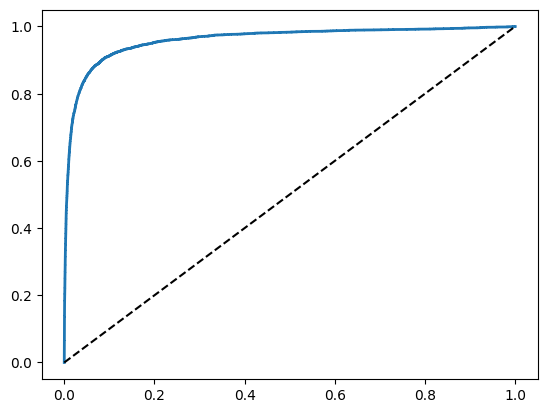

In [36]:
# matplotlib으로 곡선 그리기
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--') # 대각 점선
  [...] # 축 이름, 그리드 추가

plot_roc_curve(fpr, tpr)
plt.show()

재현율이 높을수록 분류기가 만드는 거짓 양성 증가

점선 : 완전한 랜덤 분류기 (멀어질수록 좋은 분류기)

**곡선 아래 면적(AUC)**

완벽한 분류기 : 1

완련 랜덤 분류기 : 0.5

In [37]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

**RandomForestClassifier를 훈련시켜 AUC 비교**

In [38]:
# 훈련 세트 샘플에 대한 점수 얻기
# predict_proba() 메서드 사용
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [39]:
# 양성 클래스 확률 점수로 사용
y_scores_forest = y_probas_forest[:, 1] # 양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47004 (\N{HANGUL SYLLABLE RAEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45924 (\N{HANGUL SYLLABLE DEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47112 (\N{HANGUL SYLLABLE RE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/

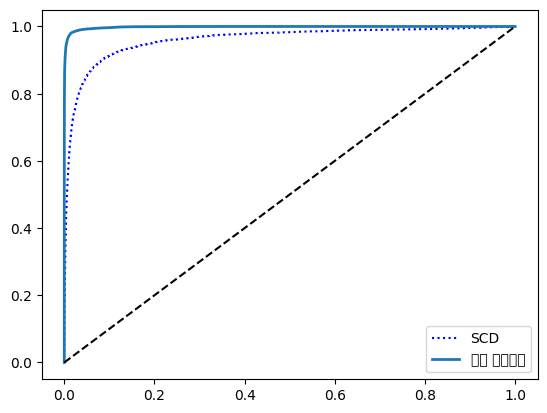

In [40]:
# ROC 곡선 그리기
plt.plot(fpr, tpr, "b:", label="SCD")
plot_roc_curve(fpr_forest, tpr_forest, "랜덤 포레스트")
plt.legend(loc = "lower right")
plt.show()

그래프 해석 : RandomForestClassifier의 ROC 곡선이 더 좋아 보임

In [41]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

# 3.4 다중 분류

**다중 분류기**

여러 개의 클래스 직접 처리 vs 이진 분류기 여러 개 사용해 다중 클래스 구분

In [ ]:
# 서포트 벡터 머신 분류기 테스트
from sklearn.svm import SVC
svm_clf= SVC()
svm_clf.fit(X_train, y_train) #y_train_5가 아니고 y_train을 사용
svm_clf.predict([some_digit])

In [ ]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

In [ ]:
np.argmax(some_digit_scores)

In [ ]:
svm_clf.classes_

In [ ]:
svm_clf.classes_[5]

**OndeVsOndeClassifier / OneVsRestClassifier**

In [ ]:
# SVC 기반으로 OvR 전략 사용하는 다중 분류기 만들기
from sklearn.multiclass import OneVsOneClassifier

ovr_clf = OneVsOneClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

In [ ]:
len(ovr_clf.estimators_)

In [ ]:
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])

In [ ]:
# decision_function() : 클래스마다 하나의 값 반환
sgd_clf.decision_function([some_digit])

**cross_val_score**

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

In [ ]:
# StandardScaler를 이용해 데이터 스케일 조정하기

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy"

# 3.5 에러 분석

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

**에러 비율**

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

In [ ]:
# 주대각선을 0으로 채워서 그래프 그리기
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
# 맷플롯립의 imshow() 사용하는 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.cm.binary, **options)
    plt.axis("off")

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

# 3.6 다중 레이블 분류

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

In [ ]:
knn_clf.predict([some_digit])

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
print(f1_score(y_multilabel, y_train_knn_pred, average="macro"))

# 3.7 다중 출력 분류

In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = plt.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [ ]:
some_index = 5501
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)